Task 1

1. ¿Qué es Programación Dinámica y cómo se relaciona con RL?
   - La Programación Dinámica (PD) es una técnica de optimización para problemas de decisión secuencial que descompone un problema grande en subproblemas más pequeños y utiliza el principio de Bellman para combinar sus soluciones. En PD se aprovechan las propiedades de estructura óptima y solapamiento de subproblemas, almacenando resultados intermedios para evitar cálculos redundantes. En el contexto de Reinforcement Learning (RL), los métodos de PD (como la iteración de valor y la iteración de póliza) utilizan un modelo completo del MDP (las probabilidades de transición y la función de recompensa) para planificar y calcular funciones de valor y políticas óptimas de forma exacta.

2. Explique en sus propias palabras el algoritmo de Iteración de Póliza.

    La Iteración de Póliza es un método de PD que alterna entre dos fases: evaluación de polí­tica y mejora de polí­tica.

   - Evaluación de polí­tica: dado una polí­tica π fija, se calcula iterativamente la función de valor V^π hasta que converge, usando la ecuación de Bellman para políticas.

   - Mejora de polí­tica: se actualiza la polí­tica eligiendo, en cada estado, la acción que maximiza la suma de recompensa inmediata más el valor descontado de los estados siguientes, según V^π. Este proceso se repite hasta que la polí­tica deja de cambiar, momento en el cual se ha encontrado la polí­tica óptima.
  
3. Explique en sus propias palabras el algoritmo de Iteración de Valor
   - La Iteración de Valor consiste en refinar continuamente nuestra apreciación de cuán valioso es cada estado, teniendo en cuenta todas las posibles acciones que podemos tomar desde ese estado y las estimaciones de valor de los estados posteriores. En cada ciclo, para cada estado, elegimos la acción que parece brindar la mejor combinación de recompensa inmediata y valor futuro estimado, y actualizamos el valor del estado en consecuencia.Este ajuste simultáneo de todos los estados se repite hasta que los valores dejan de cambiar significativamente, momento en el que hemos obtenido una estimación estable que guía la acción óptima en cada estado.
   
4. En el laboratorio pasado, vimos que el valor de los premios obtenidos se mantienen constantes, ¿por qué?
   - Porque la función de recompensa R(s, a, s’) es parte del modelo del entorno y está predefinida; sus valores inmediatos no dependen de las iteraciones ni de la polí­tica del agente. Durante la aplicación de algoritmos de PD (o de RL), únicamente se actualizan las estimaciones de la función de valor o de la polí­tica, pero los premios inmediatos por transición permanecen fijos tal como fueron definidos en el MDP (por ejemplo, +1 al alcanzar la meta y -1 al chocar con un obstáculo).

# Task 2
El objetivo principal de este ejercicio es que simule un MDP que represente un robot que navega por un laberinto de
cuadrículas de 3x3 y evalúe una política determinada.
Por ello considere, a un robot navega por un laberinto de cuadrícula de 3x3. El robot puede moverse en cuatro
direcciones: arriba, abajo, izquierda y derecha. El objetivo es navegar desde la posición inicial hasta la posición de
meta evitando obstáculos. El robot recibe una recompensa cuando alcanza la meta y una penalización si choca
con un obstáculo.

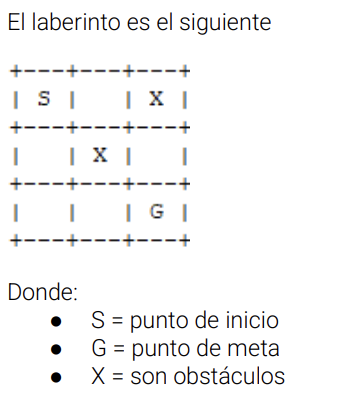

In [14]:
import numpy as np

gamma = 0.9       
theta = 1e-3       

n_states = 9
states = list(range(n_states))

actions = ['up', 'down', 'left', 'right']

In [15]:
def idx_to_pos(s):
    return divmod(s, 3)   

def pos_to_idx(i, j):
    return i * 3 + j    


In [16]:
start = 0
goal  = 8
obstacles = {2, 4}  

terminal_states = {goal}

In [17]:
P = {s: {a: {} for a in actions} for s in states}
R = {s: {a: {} for a in actions} for s in states}

for s in states:
    for a in actions:
        i, j = idx_to_pos(s)
        if s in terminal_states:
            P[s][a][s] = 1.0
            R[s][a][s] = 0.0
            continue

        if a == 'up':    ni, nj = i-1, j
        if a == 'down':  ni, nj = i+1, j
        if a == 'left':  ni, nj = i, j-1
        if a == 'right': ni, nj = i, j+1

        if not (0 <= ni < 3 and 0 <= nj < 3):
            P[s][a][s] = 1.0
            R[s][a][s] = -1.0
        else:
            s2 = pos_to_idx(ni, nj)
            if s2 in obstacles:
                P[s][a][s] = 1.0
                R[s][a][s] = -1.0
            elif s2 == goal:
                P[s][a][s2] = 1.0
                R[s][a][s2] =  1.0
            else:
                P[s][a][s2] = 1.0
                R[s][a][s2] =  0.0

In [18]:
V = np.zeros(n_states)

while True:
    delta = 0
    for s in states:
        if s in terminal_states:
            continue
        v = V[s]
        action_values = []
        for a in actions:
            ev = sum(P[s][a][s2] * (R[s][a][s2] + gamma * V[s2])
                     for s2 in P[s][a])
            action_values.append(ev)
        V[s] = max(action_values)
        delta = max(delta, abs(v - V[s]))
    if delta < theta:
        break

pi_value = {}
for s in states:
    if s in terminal_states:
        pi_value[s] = None
    else:
        best_a = max(actions,
                     key=lambda a: sum(P[s][a][s2] * (R[s][a][s2] + gamma * V[s2])
                                       for s2 in P[s][a]))
        pi_value[s] = best_a

print("Valor óptimo (Value Iteration):", V)
print("Política óptima:", pi_value)

Valor óptimo (Value Iteration): [0.729  0.6561 0.9    0.81   0.9    1.     0.9    1.     0.    ]
Política óptima: {0: 'down', 1: 'left', 2: 'down', 3: 'down', 4: 'down', 5: 'down', 6: 'right', 7: 'right', 8: None}


In [19]:
pi = {s: (None if s in terminal_states else np.random.choice(actions))
      for s in states}
V_pi = np.zeros(n_states)

def policy_evaluation(pi, V):
    while True:
        delta = 0
        for s in states:
            if s in terminal_states:
                continue
            v = V[s]
            a = pi[s]
            V[s] = sum(P[s][a][s2] * (R[s][a][s2] + gamma * V[s2])
                       for s2 in P[s][a])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

while True:
    V_pi = policy_evaluation(pi, V_pi.copy())

    policy_stable = True
    for s in states:
        if s in terminal_states:
            continue
        old_a = pi[s]
        pi[s] = max(actions,
                    key=lambda a: sum(P[s][a][s2] * (R[s][a][s2] + gamma * V_pi[s2])
                                      for s2 in P[s][a]))
        if pi[s] != old_a:
            policy_stable = False

    if policy_stable:
        break

print("Valor óptimo (Policy Iteration):", V_pi)
print("Política óptima:", pi)

Valor óptimo (Policy Iteration): [0.729  0.6561 0.9    0.81   0.9    1.     0.9    1.     0.    ]
Política óptima: {0: 'down', 1: 'left', 2: 'down', 3: 'down', 4: 'down', 5: 'down', 6: 'right', 7: 'right', 8: None}
